First, let 

To generate our estimate $\hat{Y}(t) | \mathbf{M_X}$, 

1. Find the contemporaneous lagged-coorindate vector on $\mathbf{M_X}$, $\underline{x}(t)$.
2. Find its $E + 1$ nearest neighbors. (the minimum number of points to bound a simplex in an $E$-dimensional space)
3. Denote the time indices of nearest neighbors, from closest to farthest, as $t_1, \dots, t_{E+1}$.
4. Use these indices to estimate $Y(t)$:
  \begin{equation}
      \hat{Y}(t) | \mathbf{M_X} = \sum_{i=1}^{E+1} w_i Y(t_i)
  \end{equation}

The weights are defined by 
\begin{equation}
    w_i = \frac{u_i}{\sum_{j=1}^{E+1} u_j}
\end{equation}

where 
\begin{equation}
  u_i = e^{\frac{-d[\underline{x}(t), \underline{x}(t_i)]}{d[\underline{x}(t), \underline{x}(t_1)]}}
\end{equation}

  where d is the Euclidean distance between vectors.

That is, the weights are exponentials of distances, scaled by the closest distance.


In [1]:
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_lagged_vector(X_list, index, tau, E):
    """Generate lagged vector of X: (X[index], X[index - tau], ..., X[index - tau*E - 1]).
    
    :param X_list: list of X observations at equally spaced time intervals.
    :param index: index to start from
    :param tau: time lag
    :param E: dimension of lagged vector
    
    :return: (X[index], X[index - tau], ..., X[index - tau*E - 1])
    """
    assert index >= tau * (E - 1)
    return [X_list[index - e * tau] for e in range(E)]

In [2]:
def get_CCM(X_list, Y_list, L, tau=2, E=3, test_indices=None, num_test=100, use_same=True):
    """
    Compute the correlation coeffiicent of using X's cross-mapped estimates to
    predict Y at the test_indices.
    
    :param X_list: list of X observations
    :param Y_list: list of Y observations
    :param L: Library length, i.e. number of X/Y observations to use to construct manifold for estiamtion
    :param  tau: Time lag of lagged vecotr
    :param E: dimesnion of lagged vector
    :param test_indices: indices of Y to estimate. All shou be > than L. Default is random.
    :param num_test: number of indeces to test if random
    :param use_same: If we find an X that has the exact value of the test X, then use only those Xs to generate estiamtes of Y
    
    :return: rho, the correlation coefficient of the estimates and true alues
    
    Workflow
    1 ) make all lagged vectors
    2) assign first L - first_lag to train, in kdtree
    3) predict by taking test_indices, convert
    4) find closets tin lag tree
    5) calculate weights
    6) get indices in old
    7) make estimate
    """

    length = len(X_list)
    first_lag = tau * (E - 1)
    
    train_indices = np.arange(first_lag, L)
    other_indices = np.arange(L, length)
    all_indices = np.arange(first_lag, length)
    if test_indices == None:
        test_indices = np.random.choice(other_indices, num_test, replace=False)

    # make all lagged vectors
    x_lag_list = np.array([get_lagged_vector(X_list, i, tau, E) for i in all_indices])
    y_lag_list = np.array([get_lagged_vector(X_list, i, tau, E) for i in all_indices])

    
    # put training X and Y (used for estimation) into kdtree for nearest neighbors seaerch
    x_lag_train = x_lag_list[np.ix_(train_indices - first_lag)]

    x_lagtree = cKDTree(x_lag_train, leafsize=100)

    
    
    
    Y_target = Y_list[test_indices]                                
    Y_ests = []
    
    # generate each estimate
    for k in range(len(test_indices)):
        test_index = test_indices[k]
        # for each t, find contemporaneous x[t]
        x_lag = x_lag_list[test_index - first_lag]
        

        
        # Find e+1 nearest neighbors, Calculate distances    
        distances, indices = x_lagtree.query(x_lag, k=E+1)
        min_dist = min(distances)

        
        # Case 1: we find an X that has the exact same value as the test X
        # In this case, use only those Xs that have same value as test X, and take 
        # the average of Ys
        if (use_same and min_dist == 0) or all([dist == 0 for dist in distances]):
            zipped = zip(*[(dist, i) for dist, i in zip(distances, indices) if dist == 0])
            distances, indices = zipped[0], zipped[1]
            weights = [1.0 / len(distances)] * len(distances)
            Y_est = sum([weight * Y_list[i + first_lag] for weight, i in zip(weights, indices)])
        
        # Case 2: all Xs are different
        # Use exponential weighting as in paper
        else:
            zipped = zip(*[(dist, i) for dist, i in zip(distances, indices) if dist != 0])
            distances, indices = zipped[0], zipped[1]
            min_dist = min(distances)
        
            # Calculate weights
            weights = np.array([np.exp(-dist * 1.0/ min_dist) for dist in distances])

            weights /= sum(weights)
        
            # generate estimate y^
            Y_est = sum([weight * Y_list[i + first_lag] for weight, i in zip(weights, indices)])
        
        Y_ests.append(Y_est)
    
    rho = np.corrcoef(Y_ests, Y_target)[0][1]

    
    return rho


def get_CCM_complete(X_list, Y_list, Ls, tau=2, E=3, test_indices=None, num_test=100, use_same=True):
    """
    :param X_list: list of X observations
    :param Y_list: list of Y observations
    :param Ls: Library lengths, i.e. number of X/Y observations to use to construct manifold for estiamtion
    :param  tau: Time lag of lagged vecotr
    :param E: dimesnion of lagged vector
    :param test_indices: indices of Y to estimate. All shou be > than L. Default is random.
    :param num_test: number of indeces to test if random
    :param use_same: If we find an X that has the exact value of the test X, then use only those Xs to generate estiamtes of Y
    
    :return: rhos, the correlation coefficient for each value of L
    """
    
    
    rhos = [get_CCM(X_list, Y_list, L, tau=tau, E=E, test_indices=test_indices, num_test=num_test, use_same=use_same)
           for L in Ls]
    
    for i in range(len(rhos)):
        if np.isnan(rhos[i]):
            rhos[i] = 0
    
    return rhos, Ls

# Let's simulate the dynamical system of two interacting species, governed as in Sugihara 2012 by:

\begin{equation}
    X(t + 1) = X(t) [r_{x1} - r_{x2} X(t) - \beta_{x,y} Y(t)
\end{equation}
\begin{equation}
    Y(t + 1) = Y(t) [r_{y1} - r_{y2} Y(t) - \beta_{y, x} X(t)]
\end{equation}

We aim to explore how well this can predict significance of causal effects.

In [10]:
def update_X(X, Y, r_x1=3.8, r_x2=3.8, beta_xy=0.02):
    return X * (r_x1 - r_x2 * X - beta_xy * Y)

def update_Y(X, Y, r_y1=3.5, r_y2=3.5, beta_yx=0.1):
    return Y * (r_y1 - r_y2 * Y - beta_yx * X)

time_length = 400
t_s = np.arange(0, time_length)
X = [0.4]
Y = [0.2]
for t in t_s[0:-1]:
    X.append(update_X(X[t], Y[t]))
    Y.append(update_Y(X[t], Y[t]))

X = np.array(X)
Y = np.array(Y)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:50: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


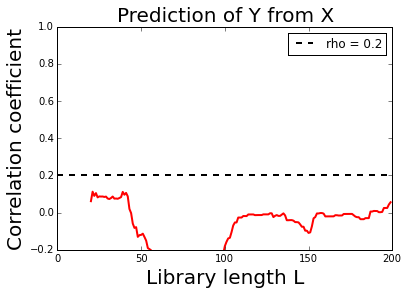

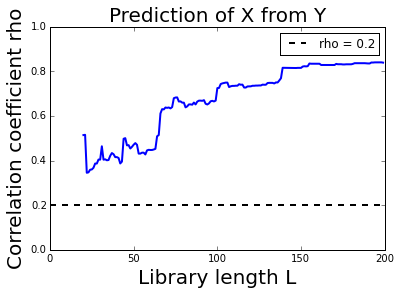

In [11]:
Ls = np.arange(20, 200)
num_test = 50
rhoXs = []
rhoYs = []
test_indices = np.random.choice(np.arange(200, 400), num_test, replace=False)
for L in Ls:
    rhoX = get_CCM(X, Y, L, test_indices=test_indices)
    rhoY = get_CCM(Y, X, L, test_indices=test_indices)
    rhoXs.append(rhoX)
    rhoYs.append(rhoY)
        
plt.plot(Ls, rhoXs, color='red', linewidth=2)
plt.xlabel("Library length L", fontsize=20)
plt.ylabel("Correlation coefficient", fontsize =20)
plt.title("Prediction of Y from X", fontsize=20)
plt.hlines(0.2, 0, 200, 'k', linestyle='dashed', linewidth=2, label="rho = 0.2")
plt.ylim(-0.2, 1)
plt.legend(loc='best')
plt.show()

plt.plot(Ls, rhoYs,linewidth=2)
plt.xlabel("Library length L", fontsize=20)
plt.ylabel("Correlation coefficient rho", fontsize =20)
plt.title("Prediction of X from Y", fontsize=20)
plt.hlines(0.2, 0, 200,  'k', linestyle='dashed', linewidth=2, label="rho = 0.2")
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

# Replicating Sugihara results on external forcing of non-coupled

\begin{equation}
R_X(t+1) = X(t)[3.1(1 - X(t))] e^{-0.3 T} \\
R_y(t+1) = Y(t)[2.9 (1 - Y(t))] e^{-0.36 T} \\
X(t+1) = 0.4 X(t) + max(R_X(t-3), 0) \\
Y(t+1) = 0.35 Y(t) + max(R_y(t-3), 0) \\
\end{equation}

R is the recruitement to adults (N)
There is a white noise environemntal variable T. There is common environmental forcing.

[ 0.69646919  0.28613933  0.22685145  0.55131477  0.71946897  0.42310646
  0.9807642   0.68482974  0.4809319   0.39211752  0.34317802  0.72904971
  0.43857224  0.0596779   0.39804426  0.73799541  0.18249173  0.17545176
  0.53155137  0.53182759  0.63440096  0.84943179  0.72445532  0.61102351
  0.72244338  0.32295891  0.36178866  0.22826323  0.29371405  0.63097612
  0.09210494  0.43370117  0.43086276  0.4936851   0.42583029  0.31226122
  0.42635131  0.89338916  0.94416002  0.50183668  0.62395295  0.1156184
  0.31728548  0.41482621  0.86630916  0.25045537  0.48303426  0.98555979
  0.51948512  0.61289453  0.12062867  0.8263408   0.60306013  0.54506801
  0.34276383  0.30412079  0.41702221  0.68130077  0.87545684  0.51042234
  0.66931378  0.58593655  0.6249035   0.67468905  0.84234244  0.08319499
  0.76368284  0.24366637  0.19422296  0.57245696  0.09571252  0.88532683
  0.62724897  0.72341636  0.01612921  0.59443188  0.55678519  0.15895964
  0.15307052  0.69552953  0.31876643  0.6919703   0.

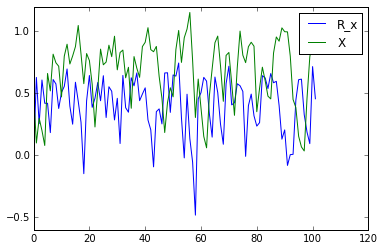

In [25]:
import numpy as np

def ext_generate_X(X_inits, time_length, lag = 3):
    assert len(X_inits) >= lag
    
    np.random.seed(123)
    Ts = np.random.uniform(0,1, time_length)
    print Ts
    Xs = X_inits[:]
    
    # Initialize the first Rs
    Rs = [0] + [Xs[i] * 3.1 * \
                (1 - Xs[i])  * \
                np.exp(-0.3 * Ts[i]) for i in range(len(Xs))]
    
    for i in range(len(X_inits) - 1, time_length):
        Rs.append(Xs[i] * 3.1 * (1 - Xs[i]) * np.exp(-0.3 * Ts[i]))
        Xs.append( 0.4 * Xs[i] + max([Rs[i - lag], 0]))
        
    return Rs, Xs


X_inits = [0.5, 0.1, 0.3, 0.2]
time_length = 100
Rs, Xs = ext_generate_X(X_inits, time_length)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(0, len(Rs)), Rs, label="R_x")
plt.plot(range(0, len(Xs)), Xs, label="X")
plt.legend()
plt.show()

# Testing values of tau and E for CCM on Sugihara dynamical system

In [ ]:
# Sketch

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


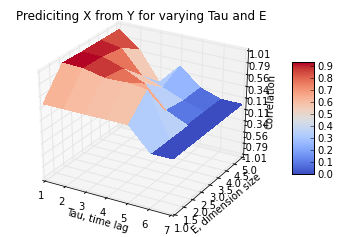

In [5]:
# How can we determine optimal values of E and Tau? Just test them all!
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

L = 200
num_tau = 7
num_E = 5
taus = np.arange(1,1 + num_tau)
Es = np.arange(1, 1 + num_E)

tauv, Ev = np.meshgrid(taus, Es)

num_test = 50
rhoXs = np.zeros(tauv.shape)
rhoYs = np.zeros(tauv.shape)
test_indices = np.random.choice(np.arange(200, 400), num_test, replace=False)
for i in range(len(tauv)):
    for j in range(len(Ev)):
        tau = tauv[j, i]
        E = Ev[j,i]
        
        rhoX = get_CCM(X, Y, L, test_indices=test_indices, tau=tau, E=E)
        rhoY = get_CCM(Y, X, L, test_indices=test_indices, tau=tau, E=E)
        rhoXs[j,i] = rhoX
        rhoYs[j,i] = rhoY

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(tauv, Ev, rhoYs, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Tau, time lag")
ax.set_ylabel("E, dimension size")
ax.set_zlabel("Correlation")
plt.title("Prediciting X from Y for varying Tau and E")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


# %matplotlib inline
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(tauv, Ev, rhoYs, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.set_xlabel("Tau, time lag", fontsize=20)
# ax.set_ylabel("E, dimension size", fontsize=20)
# ax.set_zlabel("Correlation", fontsize=20)
# plt.title("Prediciting X from Y for varying Tau and E", fontsize=20)
# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()

# Visualize the sugihara dynamical system

First values of X are  [ 0.4         0.9104      0.29992218  0.79299126  0.6158215   0.88873879
  0.36809997  0.8778534   0.39891535  0.90453599  0.31986788  0.82140757
  0.54966345  0.93146246  0.23440598  0.67809726  0.82276173  0.54028972
  0.93953162  0.20053276]
first values of Y are  [ 0.2         0.552       0.81528192  0.50263848  0.83511684  0.43051017
  0.81983796  0.48678464  0.83165618  0.45683857  0.82715713  0.47393065
  0.83369234  0.43944796  0.82123415  0.49457996  0.84135985  0.39793322
  0.81703838  0.44643999]


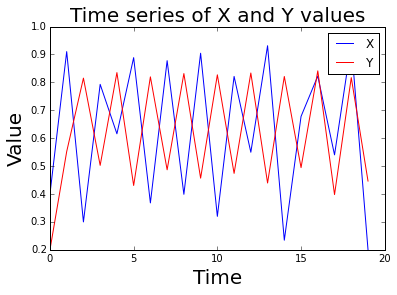

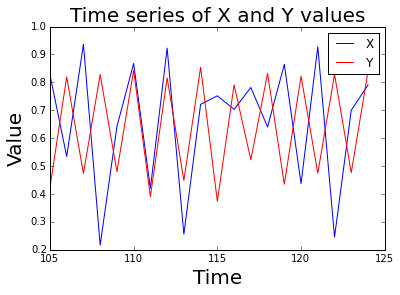

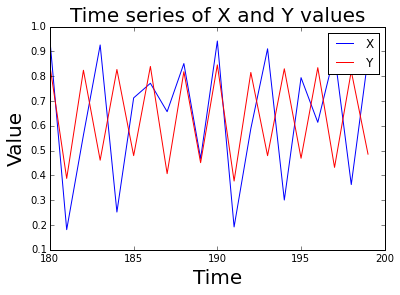

In [63]:
print "First values of X are ", X[0:20]
print "first values of Y are ", Y[0:20]

%matplotlib inline
indices_list = [np.arange(0,20), np.arange(105,125), np.arange(180, 200)]

for indices in indices_list:
    plt.plot(t_s[indices], X[indices], 'b-', label='X')
    plt.plot(t_s[indices], Y[indices], 'r-', label='Y')
    plt.legend()
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title("Time series of X and Y values", fontsize=20)
    plt.show()

## Testing CCM on  deterministic: Y = 15 + X

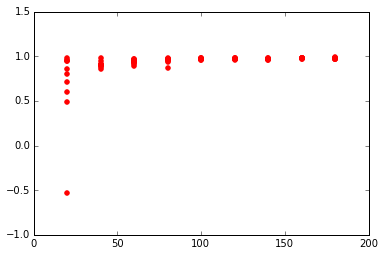

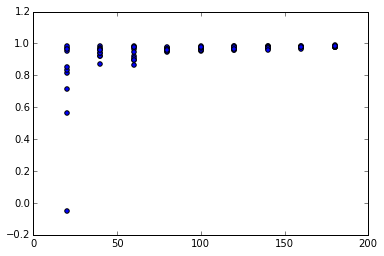

In [38]:
Ls = np.arange(20, 200, 20)
num_per = 10
all_Ls = []
rhoXs = []
rhoYs = []
for L in Ls:
    for i in range(num_per):
        all_Ls.append(L)
        X_list = np.random.permutation(np.arange(0,L))
        Y_list = X_list + 15

        rhoX = get_CCM(X_list, Y_list, int(L * 0.5), num_test=int(L*0.25))
        rhoY = get_CCM(Y_list, X_list, int(L * 0.5), num_test=int(L*0.25))
        rhoXs.append(rhoX)
        rhoYs.append(rhoY)
        
plt.scatter(all_Ls, rhoXs, color='red')
plt.show()

plt.scatter(all_Ls, rhoYs)
plt.show()

# Testing CCM on independent Gaussian Noise

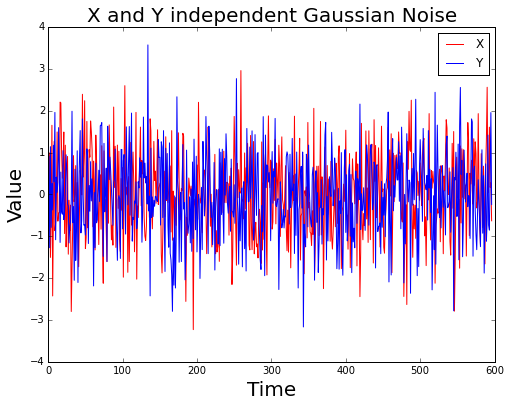

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:50: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


CPU times: user 6.89 s, sys: 55.3 ms, total: 6.94 s
Wall time: 7.04 s
CPU times: user 7.02 s, sys: 56.4 ms, total: 7.07 s
Wall time: 7.19 s


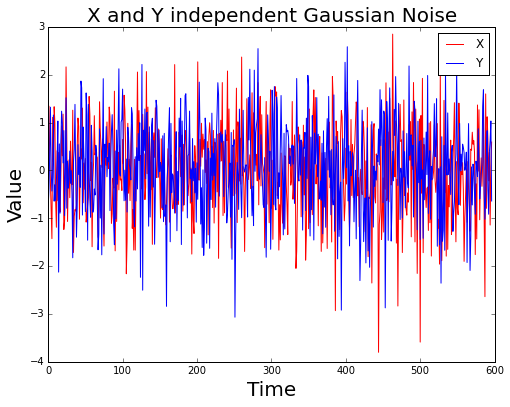

CPU times: user 6.56 s, sys: 70.9 ms, total: 6.63 s
Wall time: 6.72 s
CPU times: user 7.32 s, sys: 107 ms, total: 7.43 s
Wall time: 7.71 s


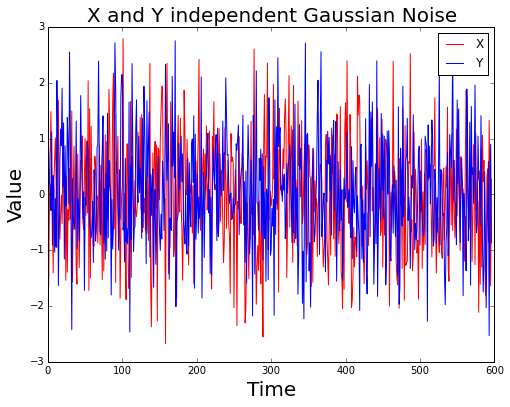

CPU times: user 7.14 s, sys: 80.7 ms, total: 7.22 s
Wall time: 7.36 s
CPU times: user 6.01 s, sys: 15.5 ms, total: 6.03 s
Wall time: 6.04 s


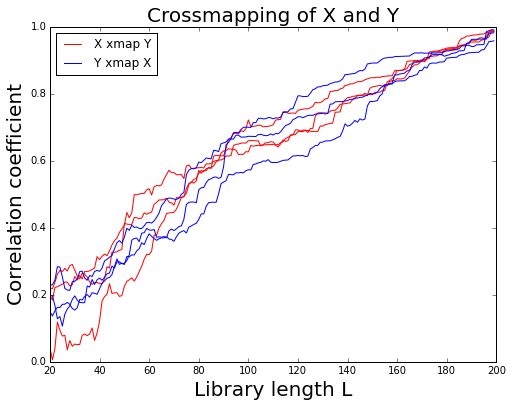

In [23]:
import numpy as np
Ls = np.arange(20, 200, 1)

all_rhoX_Ls = []
all_rhoXs = []
all_rhoY_Ls = []
all_rhoYs = []


num_test = 0.5 * max(Ls)
num_per = 3

len_list = 3*max(Ls)
test_indices = np.random.choice(max(Ls), len_list, num_test)

np.random.seed(123)
for i in range(num_per):

    X_list = np.random.normal(size=len_list)
    Y_list =np.random.normal(size=len_list)

    plt.figure(figsize=(8,6))
    plt.plot(range(len(X_list)), X_list, label="X", color='red')
    plt.plot(range(len(Y_list)), Y_list, label="Y", color='blue')
    plt.title("X and Y independent Gaussian Noise", fontsize=20)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.legend()
    plt.show()
    
    

    %time rhoXs, Ls, = get_CCM_complete(X_list, Y_list,  Ls=Ls, test_indices=test_indices)
    all_rhoX_Ls.append(Ls)
    all_rhoXs.append(rhoXs)
    
    %time rhoYs, Ls = get_CCM_complete(Y_list, X_list, Ls=Ls, test_indices=test_indices)
    all_rhoY_Ls.append(Ls)
    all_rhoYs.append(rhoYs)
    
plt.figure(figsize=(8,6))
for rhoXs, Ls in zip(all_rhoXs, all_rhoX_Ls):
    if rhoXs == all_rhoXs[0]:
        plt.plot(Ls, rhoXs, color='red', label="X xmap Y")
    else:
        plt.plot(Ls, rhoXs, color='red')
for rhoYs, Ls in zip(all_rhoYs, all_rhoY_Ls):
    if rhoYs == all_rhoYs[0]:
        plt.plot(Ls, rhoYs, color='blue', label="Y xmap X")
    else:
        plt.plot(Ls, rhoYs, color='blue')
plt.xlabel("Library length L", fontsize=20)
plt.ylabel("Correlation coefficient", fontsize =20)
plt.title("Crossmapping of X and Y", fontsize=20)
plt.legend(loc='best')
plt.show()

# Testing CCM on independent uniform noise

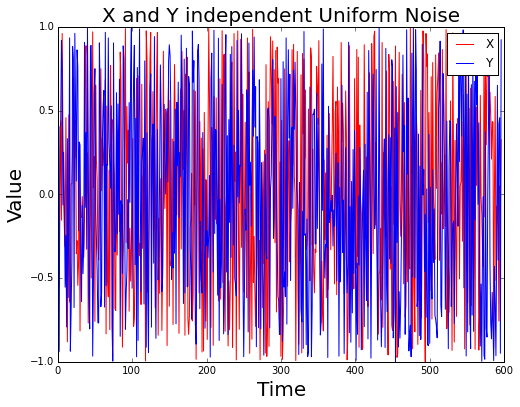

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:50: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


CPU times: user 7.48 s, sys: 90.2 ms, total: 7.57 s
Wall time: 7.81 s
CPU times: user 6.84 s, sys: 70.5 ms, total: 6.91 s
Wall time: 7.05 s


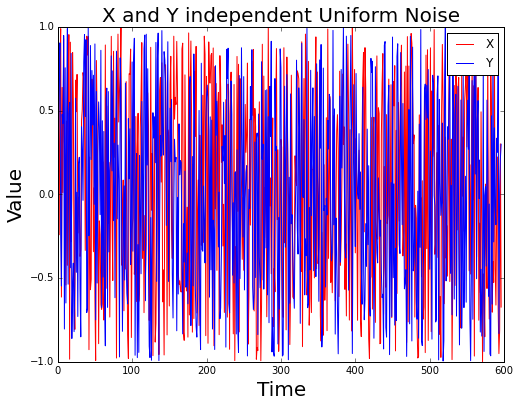

CPU times: user 6.24 s, sys: 46.2 ms, total: 6.29 s
Wall time: 6.32 s
CPU times: user 5.88 s, sys: 25 ms, total: 5.9 s
Wall time: 5.92 s


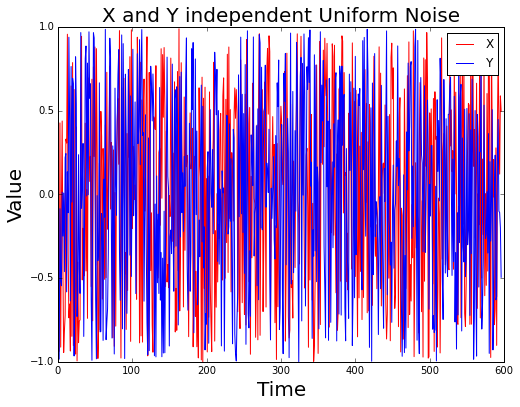

CPU times: user 6.93 s, sys: 89.8 ms, total: 7.02 s
Wall time: 7.19 s
CPU times: user 6.31 s, sys: 54.2 ms, total: 6.36 s
Wall time: 6.47 s


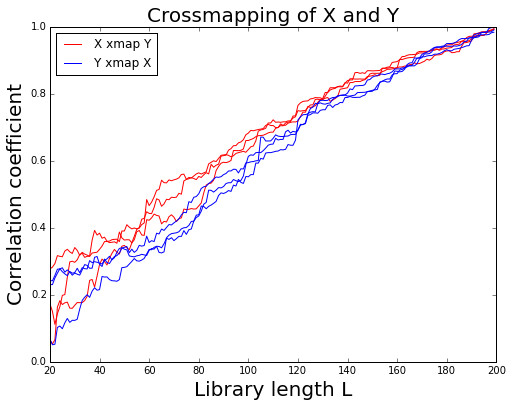

In [26]:
import numpy as np
Ls = np.arange(20, 200, 1)

all_rhoX_Ls = []
all_rhoXs = []
all_rhoY_Ls = []
all_rhoYs = []


num_test = 0.5 * max(Ls)
num_per = 3

len_list = 3*max(Ls)
test_indices = np.random.choice(max(Ls), len_list, num_test)

np.random.seed(123)
for i in range(num_per):

    X_list = np.random.uniform(-1, 1, size=len_list)
    Y_list =np.random.uniform(-1, 1,size=len_list)

    plt.figure(figsize=(8,6))
    plt.plot(range(len(X_list)), X_list, label="X", color='red')
    plt.plot(range(len(Y_list)), Y_list, label="Y", color='blue')
    plt.title("X and Y independent Uniform Noise", fontsize=20)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.legend()
    plt.show()
    
    

    %time rhoXs, Ls, = get_CCM_complete(X_list, Y_list,  Ls=Ls, test_indices=test_indices)
    all_rhoX_Ls.append(Ls)
    all_rhoXs.append(rhoXs)
    
    %time rhoYs, Ls = get_CCM_complete(Y_list, X_list, Ls=Ls, test_indices=test_indices)
    all_rhoY_Ls.append(Ls)
    all_rhoYs.append(rhoYs)
    
plt.figure(figsize=(8,6))
for rhoXs, Ls in zip(all_rhoXs, all_rhoX_Ls):
    if rhoXs == all_rhoXs[0]:
        plt.plot(Ls, rhoXs, color='red', label="X xmap Y")
    else:
        plt.plot(Ls, rhoXs, color='red')
for rhoYs, Ls in zip(all_rhoYs, all_rhoY_Ls):
    if rhoYs == all_rhoYs[0]:
        plt.plot(Ls, rhoYs, color='blue', label="Y xmap X")
    else:
        plt.plot(Ls, rhoYs, color='blue')
plt.xlabel("Library length L", fontsize=20)
plt.ylabel("Correlation coefficient", fontsize =20)
plt.title("Crossmapping of X and Y", fontsize=20)
plt.legend(loc='best')
plt.show()

# Testing CCM on independent exponential noise

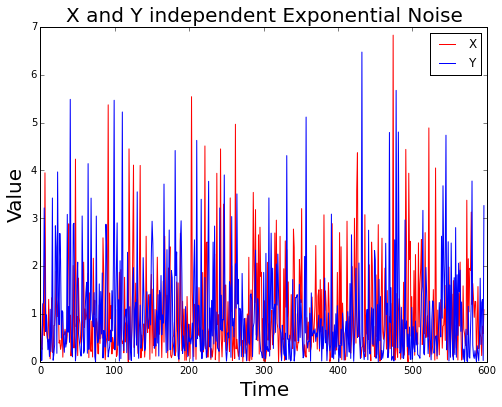

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:50: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


CPU times: user 6.29 s, sys: 37 ms, total: 6.32 s
Wall time: 6.36 s
CPU times: user 6.46 s, sys: 62 ms, total: 6.52 s
Wall time: 6.6 s


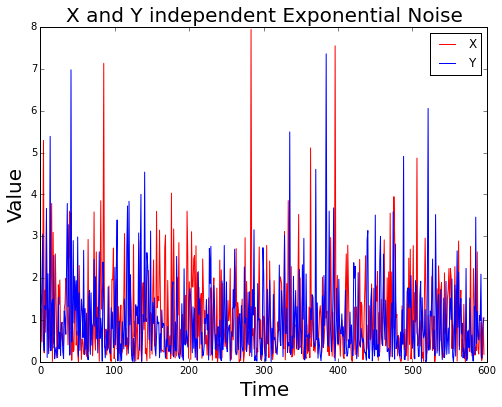

CPU times: user 6.24 s, sys: 34.8 ms, total: 6.28 s
Wall time: 6.31 s
CPU times: user 6.46 s, sys: 35.8 ms, total: 6.5 s
Wall time: 6.53 s


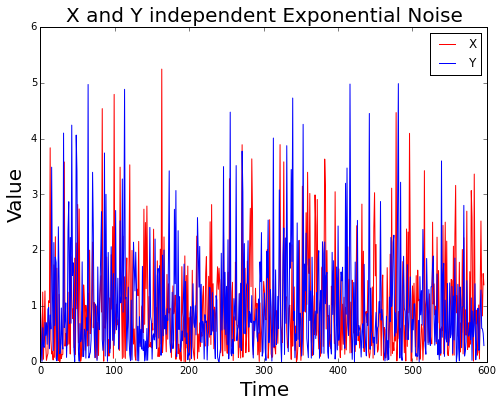

CPU times: user 6.55 s, sys: 32.3 ms, total: 6.59 s
Wall time: 6.61 s
CPU times: user 6.45 s, sys: 33.2 ms, total: 6.48 s
Wall time: 6.5 s


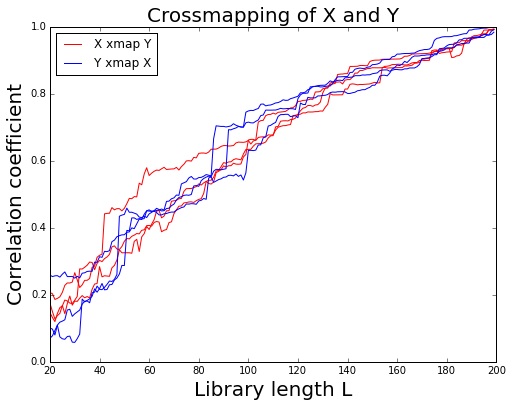

In [27]:
import numpy as np
Ls = np.arange(20, 200, 1)

all_rhoX_Ls = []
all_rhoXs = []
all_rhoY_Ls = []
all_rhoYs = []


num_test = 0.5 * max(Ls)
num_per = 3

len_list = 3*max(Ls)
test_indices = np.random.choice(max(Ls), len_list, num_test)

np.random.seed(123)
for i in range(num_per):

    X_list = np.random.exponential(size=len_list)
    Y_list =np.random.exponential(size=len_list)

    plt.figure(figsize=(8,6))
    plt.plot(range(len(X_list)), X_list, label="X", color='red')
    plt.plot(range(len(Y_list)), Y_list, label="Y", color='blue')
    plt.title("X and Y independent Exponential Noise", fontsize=20)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.legend()
    plt.show()
    
    

    %time rhoXs, Ls, = get_CCM_complete(X_list, Y_list,  Ls=Ls, test_indices=test_indices)
    all_rhoX_Ls.append(Ls)
    all_rhoXs.append(rhoXs)
    
    %time rhoYs, Ls = get_CCM_complete(Y_list, X_list, Ls=Ls, test_indices=test_indices)
    all_rhoY_Ls.append(Ls)
    all_rhoYs.append(rhoYs)
    
plt.figure(figsize=(8,6))
for rhoXs, Ls in zip(all_rhoXs, all_rhoX_Ls):
    if rhoXs == all_rhoXs[0]:
        plt.plot(Ls, rhoXs, color='red', label="X xmap Y")
    else:
        plt.plot(Ls, rhoXs, color='red')
for rhoYs, Ls in zip(all_rhoYs, all_rhoY_Ls):
    if rhoYs == all_rhoYs[0]:
        plt.plot(Ls, rhoYs, color='blue', label="Y xmap X")
    else:
        plt.plot(Ls, rhoYs, color='blue')
plt.xlabel("Library length L", fontsize=20)
plt.ylabel("Correlation coefficient", fontsize =20)
plt.title("Crossmapping of X and Y", fontsize=20)
plt.legend(loc='best')
plt.show()

# BELOW IS OLD CALCULATION for CCM


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars


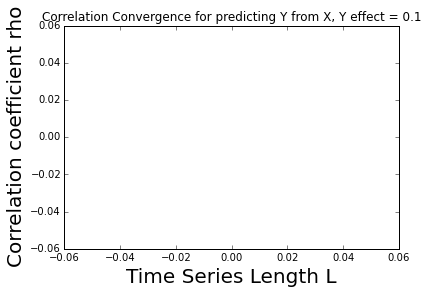

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in double_scalars


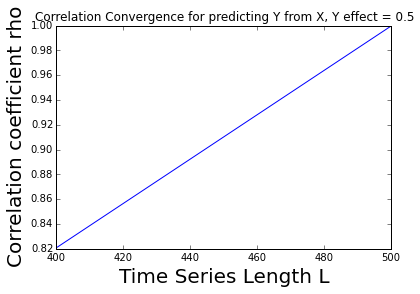

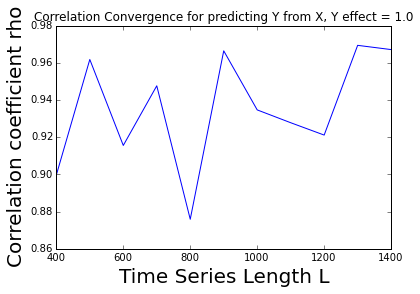

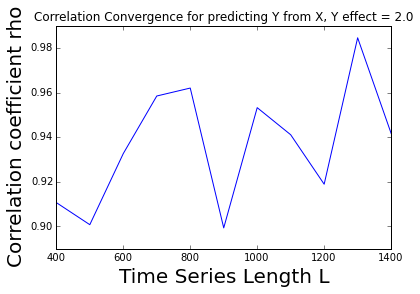

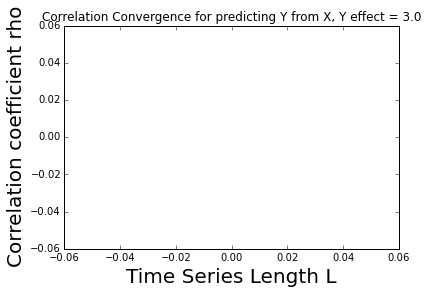

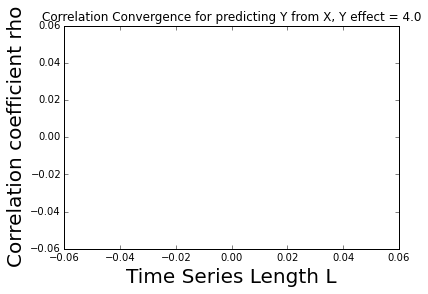

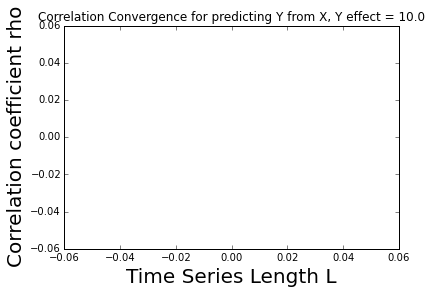

In [26]:
# Generate noiseless data
# calculatte correlation coefficient over all for Ls, plot
tau = 5
E = 10
Ls = [400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]
y_effects = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 10.0]

num_test = 100
for y_effect in y_effects:
    
    rhos = []
    for L in Ls:
        t_s = np.arange(0, L)
        first_lag = tau * (E - 1)
        train_indices = np.arange(first_lag, L/2)
        other_indices = np.arange(L/2, L)
        test_indices = np.random.choice(other_indices, num_test, replace=False)

        X = [0.4]
        Y = [0.2]
        for t in t_s[0:-1]:
            X.append(update_X(X[t], Y[t], y_effect))
            Y.append(update_Y(X[t], Y[t]))

        X = np.array(X)
        Y = np.array(Y)


        # make all lagged vectors
        x_lag = []
        y_lag = []

        t_lagged = np.arange(first_lag, L)
        for t in t_lagged:
            x_lag.append([X[t - e * tau] for e in range(E)])
            y_lag.append([Y[t - e * tau] for e in range(E)])

        x_lag = np.array(x_lag)
        y_lag = np.array(y_lag)

        #Use only half of Lagged samples for prediction
        x_lag_train = x_lag[np.ix_(train_indices - first_lag)]
        x_lagtree = cKDTree(x_lag_train, leafsize=100)    


        # Use any number of random samples from the other range

        Y_target = Y[test_indices]

        Y_ests = []

        for test_index in test_indices:
            # for each y[t], find contemporaneous x[t]
            x_con = x_lag[test_index - first_lag]

            # Find e+1 nearest neighbors, Calculate distances    
            distances, indices = x_lagtree.query(x_con, k=E+1)
            min_dist = min(distances)

            # Calculate weights
            weights = [np.exp(-dist * 1.0/ min_dist) for dist in distances]

            # generate estimate y^
            Y_est = sum([weight * Y[i + first_lag] for weight, i in zip(weights, indices)])

            Y_ests.append(Y_est)

        rhos.append(np.corrcoef(Y_ests, Y_target)[0][1])


    plt.plot(Ls, rhos)
    plt.xlabel("Time Series Length L", fontsize=20)
    plt.ylabel("Correlation coefficient rho", fontsize=20)
    plt.title("Correlation Convergence for predicting Y from X, Y effect = " + str(y_effect))
    plt.show()

# measure correlation as you go further